# Probability Amplitude Swapping Implementation 
### Parallelized and Parameterized

Date: Dec 20, 2023

Algorithm Creator: Iain Burge

Code Authors: Iain Burge (Used some of Tom Mai's Code as reference)

Paper Authors: Iain Burge, Tom Mai, Michel Barbeau

### Import Modules

In [75]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import MCXGate
from qiskit.quantum_info import Statevector

### Define Variables

In [76]:
# x = 3
# y = 113
num_bits = 3

# if num_bits is None:
#     num_bits = int(np.ceil(np.log2(max(x, y))))
m = int(np.ceil(np.log2(num_bits)))


### Define $U_{i,j}$, $a_{i,j}$, $b_{i,j}$, and $c_i$ functions

In [77]:
def bitsToString(value: int, nbits: int=None):
    if nbits is None:
        nbits = int(np.ceil(np.log2(value)))

    return f"{value:0>{nbits}b}"

def extractBit(bit: int, basis_state: int, 
        nbits: int = num_bits
    ) -> int:
    """Leftmost bit is 0"""
    return (basis_state & (1<<(nbits-bit-1))) >> (nbits-bit-1)

def setBit(bit: int, value: int, basis_state: int, 
        nbits: int = num_bits
    ) -> int:
    """Leftmost bit is 0"""
    basis_state &= ~(1<<(nbits-bit-1))
    basis_state ^= value * (1<<(nbits-bit-1))

    return basis_state

def calculateAB(i: int, j: int, x_i: int, y_i: int,
        nbits: int = num_bits
    ) -> tuple[bool, bool]:
    top_bit     = (2**i) * (2*j)
    bottom_bit  = (2**i) * (2*j + 1)

    if bottom_bit >= num_bits:
        return False, False
    
    a_ij =\
        extractBit(top_bit, x_i, nbits)    == extractBit(top_bit, y_i, nbits)
    b_ij =\
        extractBit(bottom_bit, x_i, nbits) != extractBit(bottom_bit, y_i, nbits)

    return a_ij, b_ij

def calculateC(i: int, x_m: int, nbits: int = num_bits) -> bool:
    return extractBit(i, x_m, nbits) == 0 

def U(i: int, j: int, a_ij: bool, b_ij: bool, basis_state: int, 
        nbits: int = num_bits,
    ) -> int:
    top_bit    = (2**i) * (2*j)
    bottom_bit = (2**i) * (2*j + 1)

    if bottom_bit >= num_bits:
        return basis_state

    top_value    = extractBit(top_bit, basis_state, nbits=num_bits)
    bottom_value = extractBit(bottom_bit, basis_state, nbits=num_bits)

    if a_ij and b_ij:
        top_value ^= bottom_value
    if b_ij:
        bottom_value ^= top_value
    
    basis_state = setBit(top_bit, top_value, basis_state, nbits)
    basis_state = setBit(bottom_bit, bottom_value, basis_state, nbits)

    return basis_state

# test = 14
# print(bitsToString(test, 8))
# test = setBit(4, 0, 14, 8)
# print(bitsToString(test, 8))
# print(extractBit(0,test,8))


### Calculate $a_{i,j}$, $b_{i,j}$, and $c_i$

In [78]:
def calculateParams(x: int, y: int
    ) -> tuple[list[list[bool]],list[list[bool]],list[bool]]:
    x_i = x
    y_i = y
    a = []
    b = []
    c = []

    for i in range(m):
        a.append([])
        b.append([])

        for j in range(2**(m-i-1)):
            a_ij, b_ij = calculateAB(i, j, x_i, y_i, num_bits)
            a[i].append(a_ij)
            b[i].append(b_ij)

            x_i = U(i, j, a_ij, b_ij, x_i, num_bits)
            y_i = U(i, j, a_ij, b_ij, y_i, num_bits)

    c.append(False)
    for i in range(1, num_bits):
        c.append(calculateC(i, x_m=x_i, nbits=num_bits))
            

    print(f"{(x,y)=}")
    print(f"\t{a=}")
    print(f"\t{b=}")
    print(f"\t{c=}")

    return a, b, c


### Build the Circuit

In [79]:
def transpositionGate(x: int, y:int) -> ...:
    circuit = QuantumCircuit(num_bits, name=f"{(x,y)}")

    a, b, c = calculateParams(x, y)

    #Step 1:
    for i in range(m):
        for j in range(2**(m-i-1)):
            top_bit     = (2**i) * (2*j)
            bottom_bit  = (2**i) * (2*j + 1)

            if bottom_bit >= num_bits:
                break

            if a[i][j] and b[i][j]:
                circuit.cx(bottom_bit, top_bit)
            if b[i][j]:
                circuit.cx(top_bit, bottom_bit)

        # circuit.barrier()

    #Step 2:
    for k in range(num_bits):
        if c[k]:
            circuit.x(k)

    circuit.append(
        MCXGate(num_bits-1), 
        [k for k in range(1, num_bits)]+[0]
    )

    for k in range(num_bits):
        if c[k]:
            circuit.x(k)

    #Step 3:
    for i in range(m-1, -1, -1):
        # circuit.barrier()
        for j in range(2**(m-i-1)):
            top_bit     = (2**i) * (2*j)
            bottom_bit  = (2**i) * (2*j + 1)

            if bottom_bit >= num_bits:
                break

            if b[i][j]:
                circuit.cx(top_bit, bottom_bit)
            if a[i][j] and b[i][j]:
                circuit.cx(bottom_bit, top_bit)


    circuit.draw(output="mpl")

    return circuit.to_gate()

### Full circuit

(x,y)=(2, 7)
	a=[[False, False], [False]]
	b=[[False, False], [True]]
	c=[False, False, True]
(x,y)=(3, 5)
	a=[[False, False], [False]]
	b=[[True, False], [False]]
	c=[False, False, False]
(x,y)=(4, 3)
	a=[[False, False], [False]]
	b=[[True, False], [True]]
	c=[False, False, False]
(x,y)=(0, 4)
	a=[[False, False], [False]]
	b=[[False, False], [False]]
	c=[False, True, True]


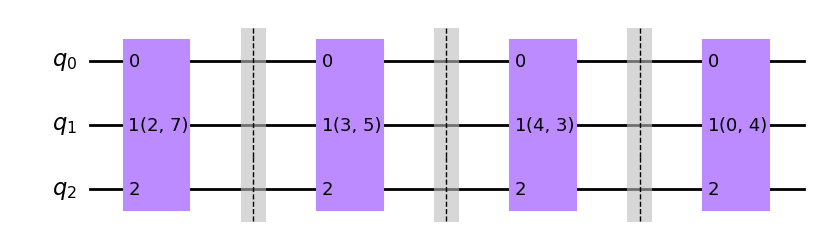

In [83]:
permutation = [(0,4), (4,3), (3,5), (2,7)]
tempPerm = permutation.copy()

circuit = QuantumCircuit(num_bits)
while len(tempPerm) > 0:
    x, y = tempPerm.pop()

    circuit.append(transpositionGate(x, y), [0,1,2])
    if len(tempPerm) > 0:
        circuit.barrier()

# circuit.draw(output='mpl')
circuit.decompose().draw(output='mpl')

### Testing

In [81]:
for z in range(2**num_bits):
    outputText = ''
    bitString = bitsToString(z, num_bits)[::-1]

    state = Statevector.from_label(bitString)
    outputText += f"Initial: |{z:>02}> = {state.draw('latex_source')}"

    state = state.evolve(circuit)

    result = state.draw('latex_source')
    result = ''.join(i for i in result if i.isdigit())
    resultInt = int(f"0b{result[::-1]}", base=2)

    outputText += f"\t->\tFinal: |{resultInt:>02}> = {state.draw('latex_source')}\t"
    outputText += "Id" if z == resultInt else "Modified"

    #print results
    print(outputText.replace(r'\rangle', '>'))

Initial: |00> =  |000>	->	Final: |04> =  |001>	Modified
Initial: |01> =  |100>	->	Final: |06> =  |011>	Modified
Initial: |02> =  |010>	->	Final: |07> =  |111>	Modified
Initial: |03> =  |110>	->	Final: |05> =  |101>	Modified
Initial: |04> =  |001>	->	Final: |03> =  |110>	Modified
Initial: |05> =  |101>	->	Final: |00> =  |000>	Modified
Initial: |06> =  |011>	->	Final: |01> =  |100>	Modified
Initial: |07> =  |111>	->	Final: |02> =  |010>	Modified
